<a href="https://colab.research.google.com/github/manojkulkarni123/FWD/blob/main/LangGraph_9_ReAct_Agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install langchain-core langchain-community langgraph langchain-openai langchain-groq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.3/423.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.7/126.7 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6

# ***ReACT***



In [3]:
# Key and llm initialization
import os
from google.colab import userdata
from langchain_groq import ChatGroq

# Now you can access your environment variables using os.environ
os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')
os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY_API_KEY')

In [4]:
# Tavily tool initialization
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

tavily_tool = TavilySearchResults(max_results=5)

In [37]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide, tavily_tool]

llm = ChatGroq(model="llama-3.3-70b-versatile")

llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

In [21]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic and search on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

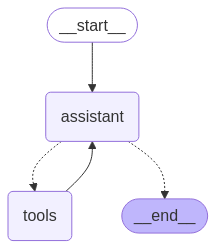

In [58]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
app = StateGraph(MessagesState)

# Define nodes: these do the work
app.add_node("assistant", assistant)
app.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
app.add_edge(START, "assistant")
app.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
app.add_edge("tools", "assistant")
react_graph = app.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [23]:
messages = [HumanMessage(content="Add 5 and 6. Multiply the output by 2. Divide the output by 5")]
messages = react_graph.invoke({"messages": messages})

In [24]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 5 and 6. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (call_bdjw)
 Call ID: call_bdjw
  Args:
    a: 5
    b: 6
================================= Tool Message =================================
Name: add

11
================================== Ai Message ==================================
Tool Calls:
  multiply (call_c8we)
 Call ID: call_c8we
  Args:
    a: 11
    b: 2
================================= Tool Message =================================
Name: multiply

22
================================== Ai Message ==================================
Tool Calls:
  divide (call_5pf7)
 Call ID: call_5pf7
  Args:
    a: 22
    b: 5
================================= Tool Message =================================
Name: divide

4.4
================================== Ai Message ==================================


In [38]:
messages = [HumanMessage(content="Search how many centruries score by Virat Kohli and then tell me the number if we add 20 more to that")]
messages = react_graph.invoke({"messages": messages})

In [39]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Search how many centruries score by Virat Kohli and then tell me the number if we add 20 more to that
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_eh6f)
 Call ID: call_eh6f
  Args:
    query: Virat Kohli centuries score
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Virat Kohli Centuries | Know When Was Kohli's Last Century - Howzat", "url": "https://www.howzat.com/blog/cricket/virat-kohli-centuries-in-odi-test-t20", "content": "Virat Kohli’s Centuries in ODI\n\nVirat Kohli has scored 50 centuries in ODI in his career playing for India. The Indian cricket team has won 42 ODI matches, tied 1, and lost 7 when Virat has scored a century. That is a staggering 84% win percentage when Virat scores an ODI hundred for India.\n\nVirat’s first ODI century

<section>


<section>


# ***aggregator***


In [71]:
from pydantic import BaseModel, Field
from typing_extensions import TypedDict

class STATE(TypedDict):
  topic:str
  poem:str
  story:str
  joke:str
  combined_output:str

In [72]:
assistant = ChatGroq(model="llama-3.3-70b-versatile")

In [73]:
def poemgen(state:STATE):

  poem = assistant.invoke(f"Generate a poem based on this topic:{state['topic']}")
  return {"poem":poem}




In [74]:
def storygen(state:STATE):

  story = assistant.invoke(f"Generate a story based on this topic:{state['topic']}")
  return {"story":story}


In [75]:
def jokegen(state:STATE):

  joke = assistant.invoke(f"Generate a joke based on this topic:{state['topic']}")
  return { "joke":joke}


In [76]:
def aggregator(state:STATE):

  output = f"Poem:{state['poem']}+\n\n+Story:{state['story']}+\n\n+Joke:{state['joke']}"
  return {"combined_output":output}

In [83]:
from langgraph.graph import START, StateGraph,END
from IPython.display import Image, display


app=StateGraph(STATE)

app.add_node("poemgen",poemgen)
app.add_node("storygen",storygen)
app.add_node("jokegen",jokegen)
app.add_node("aggregator",aggregator)

app.add_edge(START,"poemgen")
app.add_edge(START,"storygen")
app.add_edge(START,"jokegen")
app.add_edge("jokegen","aggregator")
app.add_edge("storygen","aggregator")
app.add_edge("poemgen","aggregator")
app.add_edge("aggregator",END)

parallel_builder=app.compile()

parallel_builder.get_graph(xray=True).draw_mermaid()


'---\nconfig:\n  flowchart:\n    curve: linear\n---\ngraph TD;\n\t__start__([<p>__start__</p>]):::first\n\tpoemgen(poemgen)\n\tstorygen(storygen)\n\tjokegen(jokegen)\n\taggregator(aggregator)\n\t__end__([<p>__end__</p>]):::last\n\t__start__ --> jokegen;\n\t__start__ --> poemgen;\n\t__start__ --> storygen;\n\taggregator --> __end__;\n\tjokegen --> aggregator;\n\tpoemgen --> aggregator;\n\tstorygen --> aggregator;\n\tclassDef default fill:#f2f0ff,line-height:1.2\n\tclassDef first fill-opacity:0\n\tclassDef last fill:#bfb6fc\n'

In [82]:
state = parallel_builder.invoke({"topic": "life"})
print(state["combined_output"])

Poem:content="Life, a journey we all must take,\nA path unwinding, for our hearts to make.\nWith every step, a story's spun,\nOf trials and tribulations, of joy and fun.\n\nInnocence and wonder, in childhood's eyes,\nA world of discovery, where dreams arise.\nThe laughter and tears, the loves and the fears,\nShape us into who we are, through all the years.\n\nAs we grow, our paths begin to stray,\nThrough labyrinths of choice, we find our way.\nWe chase our passions, we follow our hearts,\nAnd in the pursuit, our true selves start.\n\nIn the depths of struggle, we find our strength,\nIn the darkness of night, a light at length.\nFor life is a tapestry, rich and bold,\nWoven with threads of love, of loss, of gold.\n\nThrough every moment, we're given a choice,\nTo find the beauty, or to hear the voice,\nOf doubt and fear, that whispers in our ear,\nBut still we rise, and banish every fear.\n\nFor life is precious, a gift so rare,\nA fleeting breath, a moment we must share.\nSo let us ch

</section>

# ***next***
